In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# Read Dataset "norway_new_car_sales_by_month.csv" as df_month
df_month = pd.read_csv("norway_new_car_sales_by_month.csv")

In [3]:
df_sales = df_month[["Year","Month","Quantity"]]

In [4]:
df_sales

,Year,Month,Quantity
0,2007,1,12685
1,2007,2,9793
2,2007,3,11264
3,2007,4,8854
4,2007,5,12007
...,...,...,...
116,2016,9,13854
117,2016,10,11932
118,2016,11,13194
119,2016,12,13602


In [5]:
df_sales['DATE'] = pd.to_datetime(df_sales[['Year', 'Month']].assign(DAY=1))

C:\Users\rcuza\AppData\Local\Temp\ipykernel_26536\472709845.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales['DATE'] = pd.to_datetime(df_sales[['Year', 'Month']].assign(DAY=1))


In [6]:
df_sales.drop(['Year', 'Month'], axis=1, inplace=True)

C:\Users\rcuza\AppData\Local\Temp\ipykernel_26536\3781488896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sales.drop(['Year', 'Month'], axis=1, inplace=True)


In [7]:
df_sales = df_sales[['DATE', 'Quantity']]

In [8]:
df_sales

,DATE,Quantity
0,2007-01-01,12685
1,2007-02-01,9793
2,2007-03-01,11264
3,2007-04-01,8854
4,2007-05-01,12007
...,...,...
116,2016-09-01,13854
117,2016-10-01,11932
118,2016-11-01,13194
119,2016-12-01,13602


In [9]:
df_sales_indexed = df_sales.set_index(['DATE'])

In [10]:
df_sales_indexed

,Quantity
DATE,
2007-01-01,12685
2007-02-01,9793
2007-03-01,11264
2007-04-01,8854
2007-05-01,12007
...,...
2016-09-01,13854
2016-10-01,11932
2016-11-01,13194


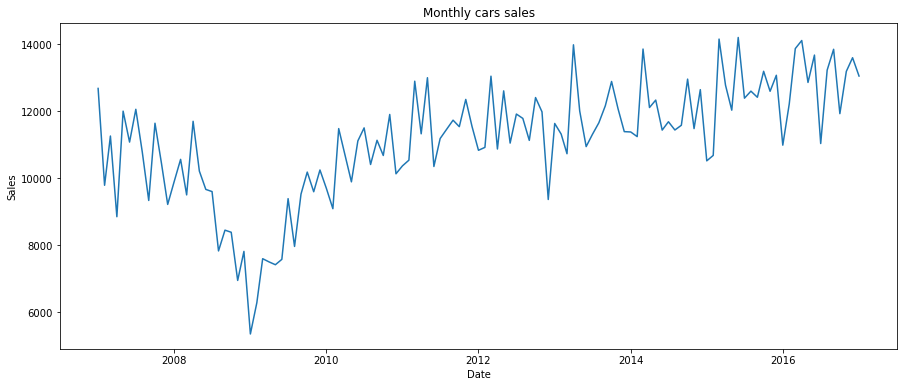

In [11]:
# Visualization

plt.plot(df_sales['DATE'],df_sales['Quantity'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly cars sales')
plt.show()

#### Check if data is stationary:

In [12]:
rolmean=df_sales_indexed.rolling(window=12).mean()
rolstd=df_sales_indexed.rolling(window=12).std()
print(rolmean.head(15))
print(rolstd.head(15))

            Quantity
DATE                
2007-01-01       NaN
2007-02-01       NaN
2007-03-01       NaN
2007-04-01       NaN
2007-05-01       NaN
2007-06-01       NaN
2007-07-01       NaN
2007-08-01       NaN
2007-09-01       NaN
2007-10-01       NaN
2007-11-01       NaN
2007-12-01  10766.25
2008-01-01  10534.25
2008-02-01  10598.75
2008-03-01  10452.25
               Quantity
DATE                   
2007-01-01          NaN
2007-02-01          NaN
2007-03-01          NaN
2007-04-01          NaN
2007-05-01          NaN
2007-06-01          NaN
2007-07-01          NaN
2007-08-01          NaN
2007-09-01          NaN
2007-10-01          NaN
2007-11-01          NaN
2007-12-01  1248.395488
2008-01-01  1110.469690
2008-02-01  1085.703385
2008-03-01  1106.192004


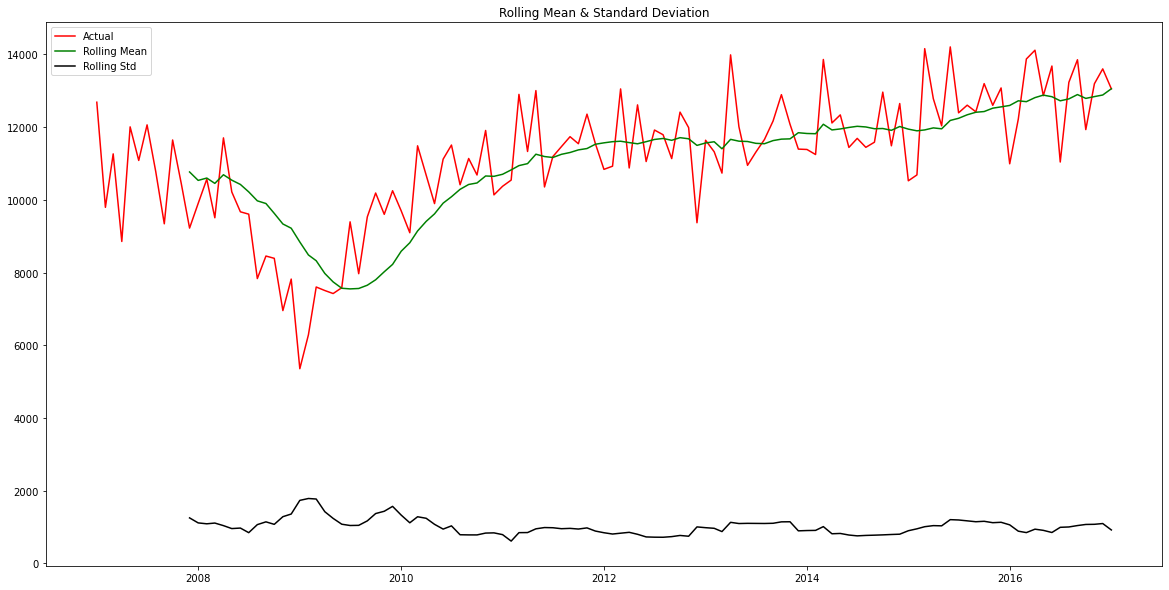

In [13]:
plt.figure(figsize=(20,10))
actual=plt.plot(df_sales_indexed, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [14]:
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
        
adf_test(df_sales_indexed['Quantity'])

1. ADF :  -0.9724745635068119
2. P-Value :  0.7631707417462781
3. Num Of Lags :  6
4. Num Of Observations Used For ADF Regression: 114
5. Critical Values :
	 1% :  -3.489057523907491
	 5% :  -2.887246327182993
	 10% :  -2.5804808802708528


- Here the value of p-value is larger than 0.05. Also, the mean and the covariance are not constant (from the graph). So the data is not stationary.

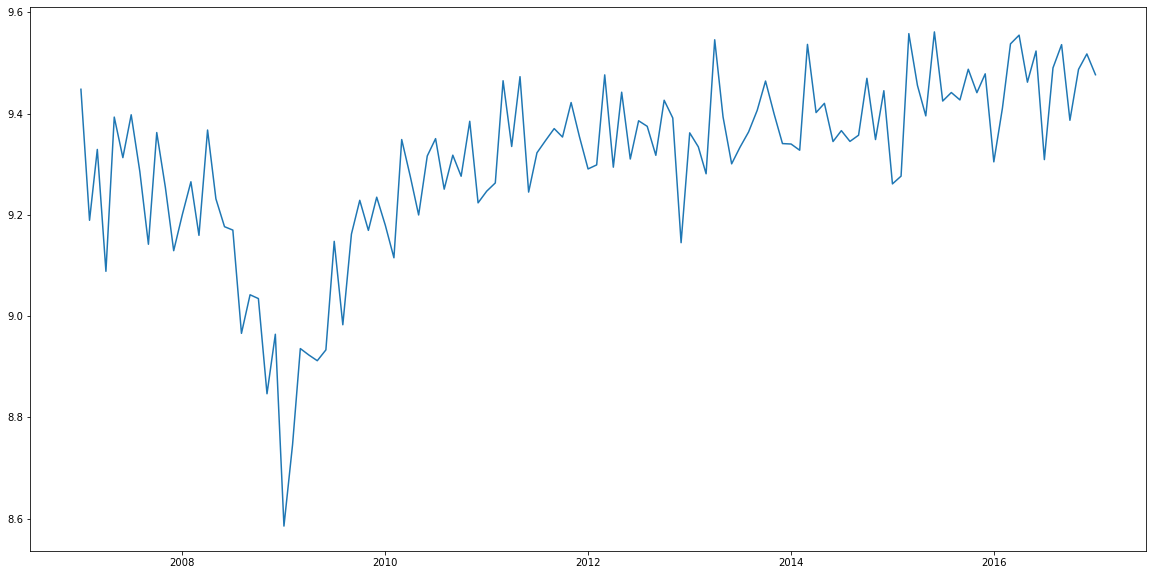

In [15]:
# Getting the Log:
plt.figure(figsize=(20,10))
data_log=np.log(df_sales_indexed)
plt.plot(data_log)

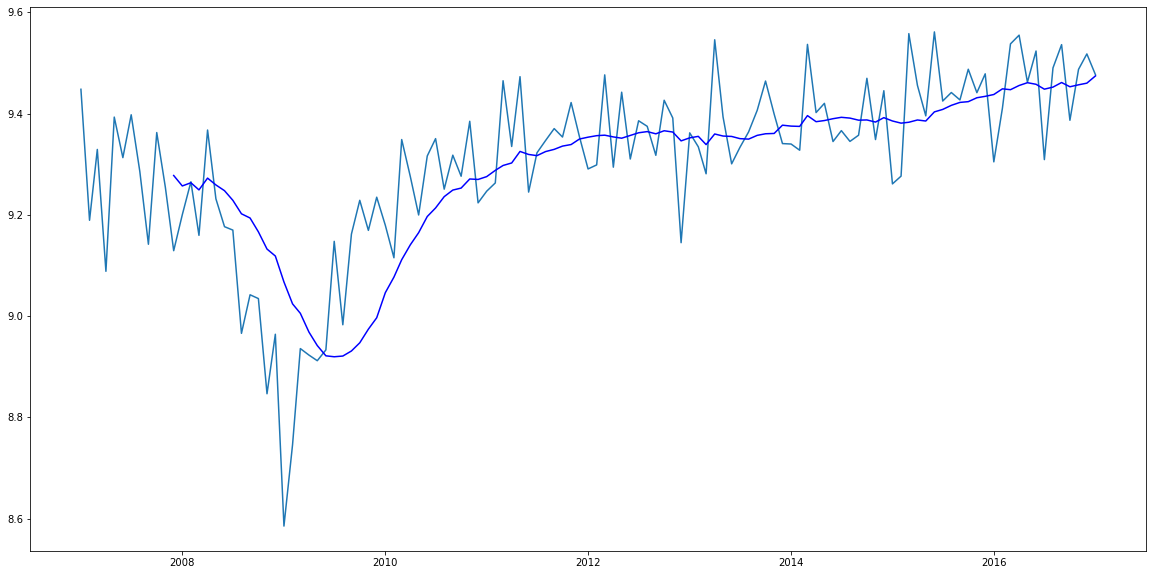

In [16]:
# Moving avg for log Data:
plt.figure(figsize=(20,10))
MAvg=data_log.rolling(window=12).mean()
MStd=data_log.rolling(window=12).std()
plt.plot(data_log)
plt.plot(MAvg, color='blue')

- Defferencing:

In [17]:
data_log_diff=data_log-MAvg
data_log_diff.head(12)

,Quantity
DATE,
2007-01-01,NaN
2007-02-01,NaN
2007-03-01,NaN
2007-04-01,NaN
2007-05-01,NaN
2007-06-01,NaN
2007-07-01,NaN
2007-08-01,NaN
2007-09-01,NaN


In [18]:
data_log_diff=data_log_diff.dropna()
data_log_diff.head()

,Quantity
DATE,
2007-12-01,-0.148536
2008-01-01,-0.056843
2008-02-01,0.001918
2008-03-01,-0.089754
2008-04-01,0.094998


In [19]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['Quantity'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

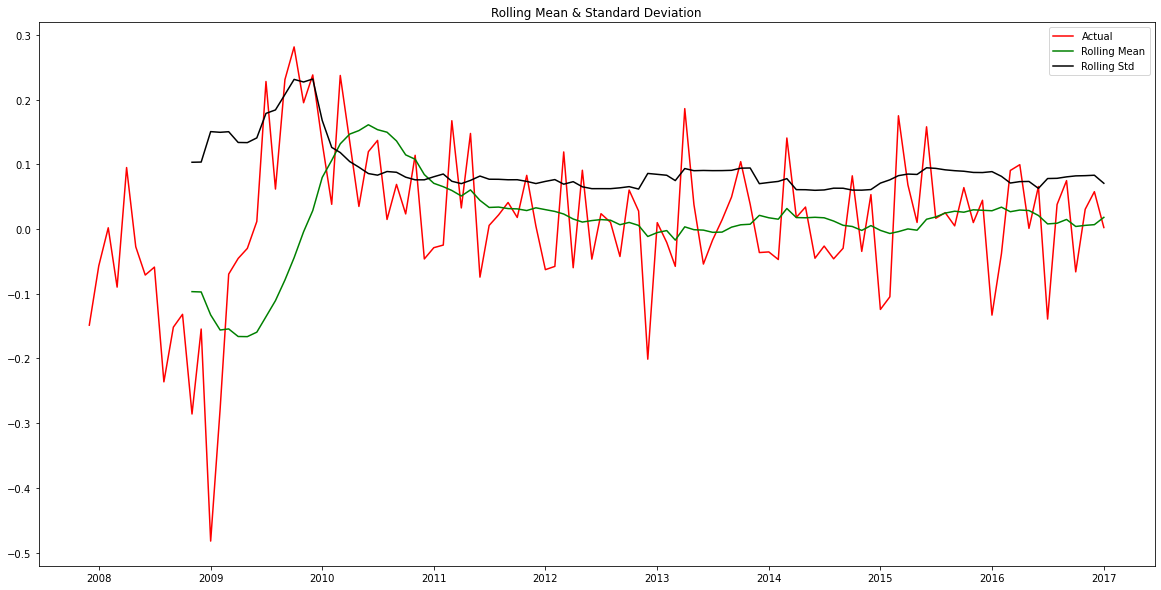

Dickey-Fuller Test: 
Test Statistic          -3.231725
p-value                  0.018220
Lags Used               11.000000
No. of Obs              98.000000
Critical Value (1%)     -3.498910
Critical Value (5%)     -2.891516
Critical Value (10%)    -2.582760
dtype: float64


In [20]:
stationarity(data_log_diff)

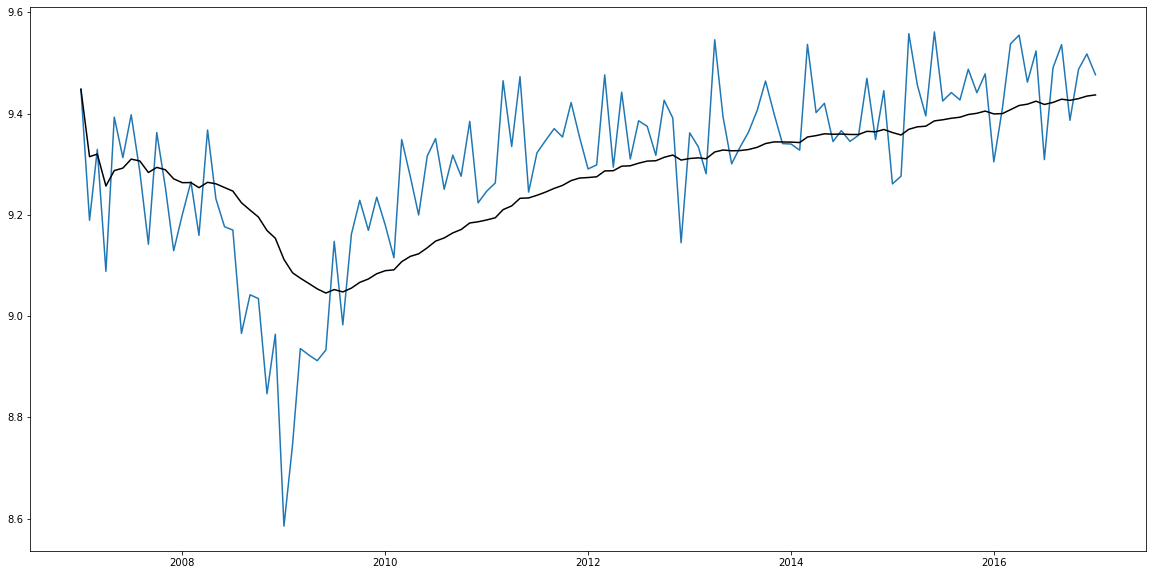

In [21]:
plt.figure(figsize=(20,10))
exp_data=data_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(data_log)
plt.plot(exp_data, color='black')

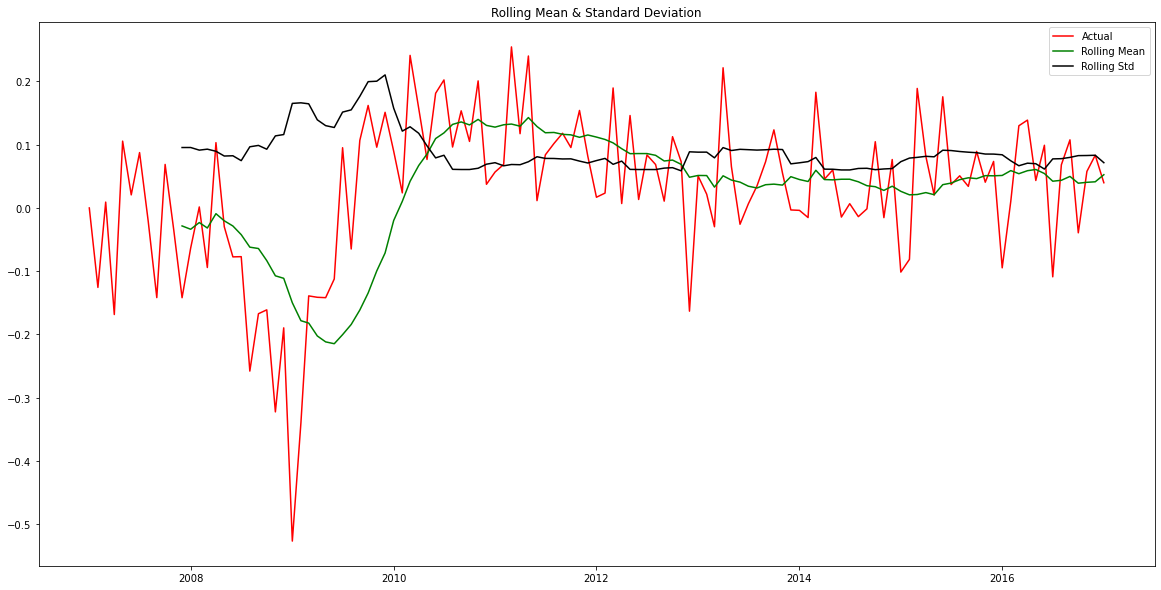

Dickey-Fuller Test: 
Test Statistic           -1.942057
p-value                   0.312542
Lags Used                11.000000
No. of Obs              109.000000
Critical Value (1%)      -3.491818
Critical Value (5%)      -2.888444
Critical Value (10%)     -2.581120
dtype: float64


In [22]:
exp_data_diff=data_log-exp_data
stationarity(exp_data_diff)

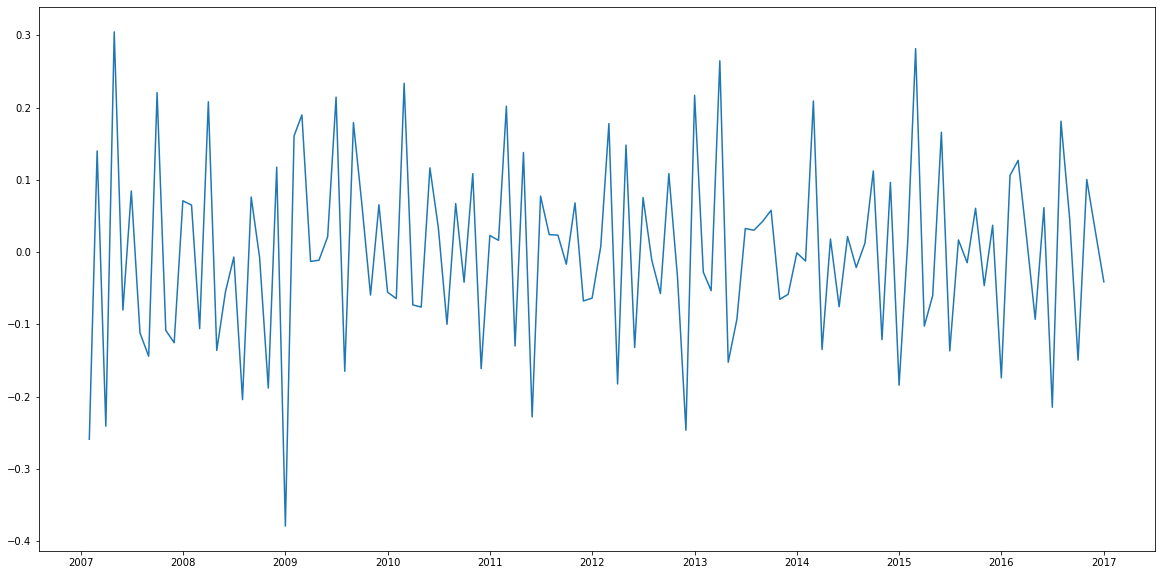

In [23]:
plt.figure(figsize=(20,10))
data_shift=data_log-data_log.shift()
plt.plot(data_shift)

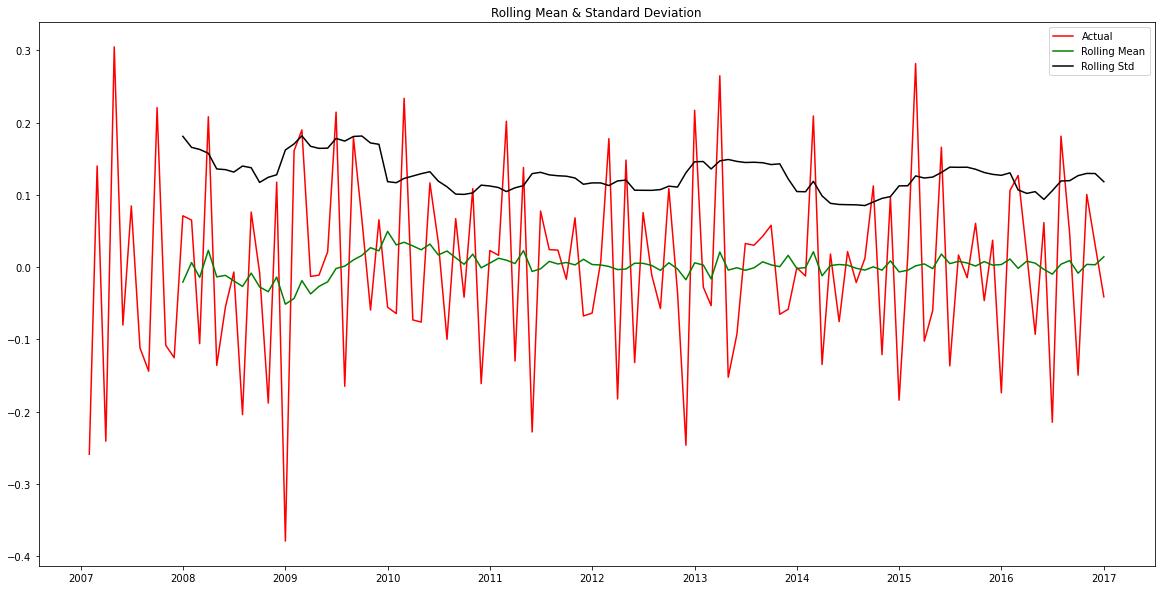

Dickey-Fuller Test: 
Test Statistic           -4.250220
p-value                   0.000541
Lags Used                10.000000
No. of Obs              109.000000
Critical Value (1%)      -3.491818
Critical Value (5%)      -2.888444
Critical Value (10%)     -2.581120
dtype: float64


In [24]:
data_shift=data_shift.dropna()
stationarity(data_shift)

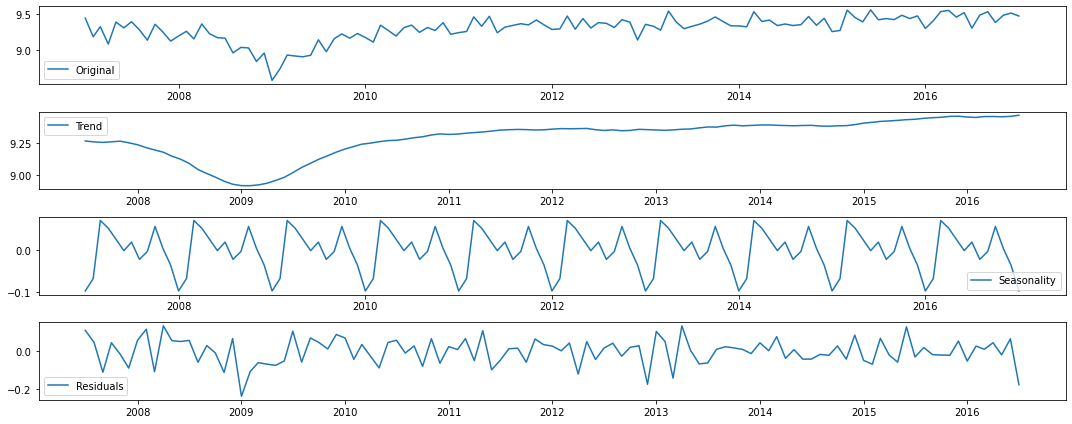

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(data_log)

trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- Preparing the data for the ARIMA model:

In [26]:
data_log_month = data_log.copy(deep=True)

In [27]:
data_log_month.index = pd.DatetimeIndex(data_log_month.index).to_period('M')

In [28]:
data_log_month.head(5)

,Quantity
DATE,
2007-01,9.448175
2007-02,9.189423
2007-03,9.329367
2007-04,9.088625
2007-05,9.393245


#### Train and Test the model:

- Get the optimal values for p, q and d:

In [29]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(data_log_month['Quantity'], error_action='ignore', trace=6,  seasonal=True, m=30)

Performing stepwise search to minimize aic
Near non-invertible roots for order (2, 1, 2)(1, 0, 1, 30); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=-147.688, Time=0.02 sec
First viable model found (-147.688)
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=-180.339, Time=0.30 sec
New best model found (-180.339 < -147.688)
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=-190.043, Time=0.33 sec
New best model found (-190.043 < -180.339)
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=-149.687, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=-191.537, Time=0.05 sec
New best model found (-191.537 < -190.043)
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=-190.389, Time=0.25 sec
Near non-invertible roots for order (0, 1, 1)(1, 0, 1, 30); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
 ARIMA(0,1

In [30]:
# Spliting Train and Test Data
print(data_log_month.shape)
train=data_log_month.iloc[:-30]
test=data_log_month.iloc[-30:]
print(train.shape,test.shape)

(121, 1)
(91, 1) (30, 1)


- Train and Test the ARIMA model:

In [31]:
model=ARIMA(train['Quantity'],order=(0,1,1), seasonal_order=(0,1,1,12))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                         Quantity   No. Observations:                   91
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  52.474
Date:                          Fri, 11 Nov 2022   AIC                            -98.947
Time:                                  19:08:56   BIC                            -91.877
Sample:                              01-31-2007   HQIC                           -96.117
                                   - 07-31-2014                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5491      0.093     -5.913      0.000      -0.731      -0.367
ma.S.L12      -0.9930     10.605     -0.094      0.925     -21.779      19.793
sigma2         0.0112      0.118      0.095      0.925      -0.221       0.243
===================================================================================
Ljung-Box (L1) (Q):                   2.24   Jarque-Bera (JB):                 1.03
Prob(Q):                              0.13   Prob(JB):                         0.60
Heteroskedasticity (H):               0.36   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Draw the predicted results for Test data:

<AxesSubplot:xlabel='DATE'>

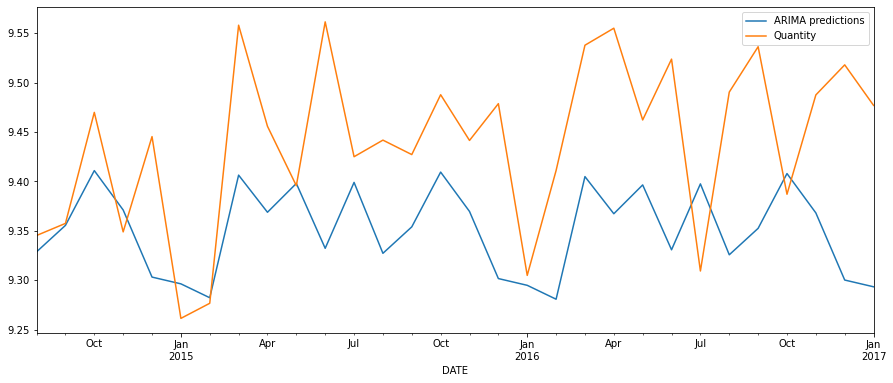

In [32]:
start=len(train)
end=len(train)+len(test)-1

pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')

pred.plot(legend=True)
test['Quantity'].plot(legend=True)

- Calculate the RMSE:

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['Quantity']))
print(rmse)

0.12205502530641632


- Predictions for Year 2020:

In [35]:
index_future_dates=pd.date_range(start='2020-01',end='2020-12')
print(index_future_dates)
pred=model.predict(start=len(data_log_month),end=len(data_log_month)+335,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25',
               '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29',
               '2020-11-30', '2020-12-01'],
              dtype='datetime64[ns]', length=336, freq='D')
2020-01-01    9.279220
2020-01-02    9.403341
2020-01-03    9.365755
2020-01-04    9.394929
2020-01-05    9.329253
                ...   
2020-11-27    9.310601
2020-11-28    9.366051
2020-11-29    9.326209
2020-11-30    9.258258
2020-12-01    9.251421
Freq: D, Name: ARIMA Predictions, Length: 336, dtype: float64


In [36]:
predictions_df = pd.DataFrame([pred])

In [37]:
predictions_df = predictions_df.transpose()

In [38]:
predictions_df.reset_index(inplace=True)

In [39]:
predictions_df = predictions_df.rename({'index': 'Date'}, axis=1)

In [40]:
# Getting the exponential to reverse the Log and get the real forcat values:
predictions_df['ARIMA Predictions'] = np.exp(predictions_df['ARIMA Predictions'])

In [41]:
Final = predictions_df.groupby(predictions_df['Date'].dt.strftime('%B'))['ARIMA Predictions'].mean()

In [42]:
print("Predictions for each month of 2020:")
Final

Predictions for each month of 2020:


Date
April        11333.465312
August       11182.498478
December     10419.359824
February     11445.591953
January      11516.355844
July         11285.021550
June         11267.532358
March        11430.577571
May          11369.672253
November     11089.158833
October      11084.262457
September    11184.418819
Name: ARIMA Predictions, dtype: float64